In [536]:
# General Imports
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Iterable, Any

# Tensorflow Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

# Scikit Keras wrapper
from scikeras.wrappers import KerasRegressor

# Custom imports
from pendulum import Pendulum_2D

In [602]:
class HNN(keras.Sequential):
    
    def __init__(self): 
        
        super(HNN, self).__init__()
        
        self.initial_state = tf.convert_to_tensor([np.pi/4, 0])
        self.m = 10
        self.l = 10
        self.g = 9.81
    
    @tf.function
    def train_step(self, data):
        
        # Unpack the data. 
        time, _ = data 
            
        # Watch gradients for backpropagation
        with tf.GradientTape() as tape:
            
            # Watch gradients for calculating time derivative of output for loss
            with tf.GradientTape() as tape2: 
                tape2.watch(time) 
                nn_result = self(time, training=True)  # Forward pass
                tape2.watch(nn_result)
                state_pred = self.parametric_equation(time, nn_result)
            
            # Create LHS and RHS of Hamilton equations
            state_deriv_from_ad = tape2.gradient(state_pred, time) 
            state_deriv_from_hamilton = self.hamilton_equations(state_pred)
            
            # Compute the loss value
            loss = self.compiled_loss(state_deriv_from_ad, state_deriv_from_hamilton, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(state_deriv_from_ad, state_deriv_from_hamilton)
        
        return {m.name: m.result() for m in self.metrics}
    
    
    def hamilton_equations(self, tens): 
        
        q_tens = tens[:,:2]
        p_tens = tens[:,2:]
        
        q_deriv = tf.multiply(p_tens, 1./(self.m*self.l*self.l))
        p_deriv = tf.multiply(p_tens, -9.81 * self.m * self.l) 
        
        deriv = tf.concat([q_deriv, p_deriv], axis = 1)
        
        return deriv
    
    def parametric_equation(self, times, states): 
        
        f = 1 - tf.math.exp(-times)
        result = self.initial_state + f * states

        return result


In [603]:
def build_hnn(hidden_layer_sizes: Iterable[int], 
              meta: Dict[str, Any]):
    
    # Create an HNN
    model = HNN()
    
    # Define input layer, always 1 dimenstion: time
    inp = keras.layers.Input(shape=(1,))
    model.add(inp)
    
    # Define hidden layer structure
    for hidden_layer_size in hidden_layer_sizes:
        layer = keras.layers.Dense(hidden_layer_size, activation="tanh")
        model.add(layer)
    
    # Final layer
    out = keras.layers.Dense(2, activation="tanh")
    model.add(out)

    return model

In [610]:
# System parameters
m = 10
l = 10

# Initial condition
y0 = np.array([np.pi/4, 0]) 
t0 = 0

# Integration
tfinal = 100
time_step = 0.1

# Create benchmark 
bench = Pendulum_2D(m, l)
bench.set_initial_condition(t0, y0, "generalized")
bench.integrate("dop853", tfinal, "generalized", rtol = 1e-12, atol = 1e-12)
bench.calculate_coordinates("canonical")

In [605]:
# Training data times
N = 200
train_time = np.linspace(t0, tfinal, N).reshape(-1, 1)
dummy_targets = np.zeros((N, 2)) 

regr = KerasRegressor(model=build_hnn, 
                           hidden_layer_sizes=(50, 50),
                           optimizer="adam",
                           epochs = 200,
                           loss="mae",
                           optimizer__learning_rate=0.01, 
                           run_eagerly=True, 
                          batch_size = 30)

In [606]:
regr.fit(train_time, dummy_targets, verbose = 0)

KerasRegressor(
	model=<function build_hnn at 0x000001CA97050280>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=mae
	metrics=None
	batch_size=30
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=True
	epochs=200
	hidden_layer_sizes=(50, 50)
	optimizer__learning_rate=0.01
)

In [607]:
def parametric_equation(times, states, initial_state): 
        
    f = 1 - np.exp(-times)
    result = np.repeat(np.array([initial_state]), len(states), axis=0) + f * states

    return result

states = parametric_equation(train_time, regr.predict(train_time), np.array([np.pi/4, 0]))

7/7 [==============================] - 0s 2ms/step


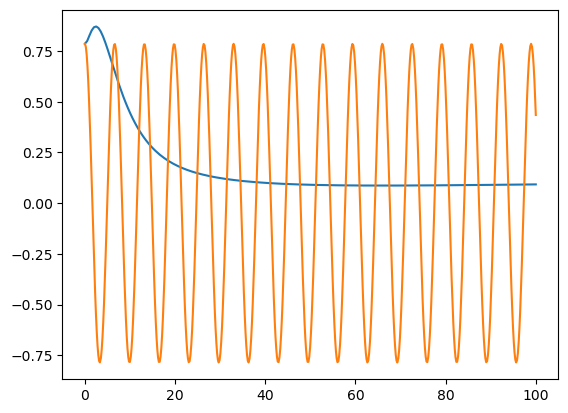

In [611]:
plt.plot(train_time[:,0], states[:,0])
plt.plot(bench.states['canonical'][:,0], bench.states['canonical'][:,1])

In [400]:
tens = tf.convert_to_tensor([[1, 2, 3, 4], [5, 6, 7, 8]], dtype=tf.float32 )

def hamilton_equation(tens, m, l): 
            
        deriv = tf.zeros(tens.shape)
        q_tens = tens[:,:2]
        p_tens = tens[:,2:]
        
        q_deriv = tf.multiply(p_tens, 1./(m*l*l))
        p_deriv = tf.multiply(p_tens, -9.81 * m *l) 
        
        deriv = tf.concat([q_deriv, p_deriv], axis = 1)
        
        return deriv 

In [406]:
states = tf.convert_to_tensor([[1, 2, 3, 4], [5, 6, 7, 8]], dtype=tf.float32 )
state_0 = tf.convert_to_tensor([[1, 2, 3, 4]], dtype=tf.float32 )

times = tf.convert_to_tensor([[1.3],[3.4]], dtype=tf.float32) 

def parametric_equation(times, states, state_0): 
        
    f = 1 - np.exp(-times)
    result = state_0 + f*states

    return result

parametric_equation(times, states, state_0)

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[ 1.7274683,  3.4549365,  5.1824045,  6.909873 ],
       [ 5.8331337,  7.799761 ,  9.766388 , 11.733014 ]], dtype=float32)>